In [462]:
import numpy as np
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt
from qiskit.synthesis import SuzukiTrotter
from scipy.optimize import minimize, linprog
from scipy.linalg import eigh, eig
import random
import cmath

In [513]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.eye(2)

n = 4

# coeffs = [1,2,3]
# Us = [np.kron(X, X), np.kron(Y,Y), np.kron(Z,Z)]  # 2 qubit Hamiltonian terms

# coeffs = [1,2,3,1,2,3]
# Us = [np.kron(np.kron(X, X), I), np.kron(np.kron(Y, Y), I), np.kron(np.kron(Z, Z), I), np.kron(I, np.kron(X, X)), np.kron(I, np.kron(Y, Y)), np.kron(I, np.kron(Z, Z))]   # 3 qubit Hamiltonian terms

coeffs = [1,1]
Us = [np.kron(np.kron(Z,X), np.kron(Z,I)), np.kron(np.kron(I,Z), np.kron(X,Z))]

# coeffs = [1,1,1]
# Us = [np.kron(np.kron(Z,X), np.kron(Z,np.kron(I,I))), np.kron(np.kron(I,Z), np.kron(X,np.kron(Z,I))), np.kron(np.kron(np.kron(I,I),Z), np.kron(X,Z))]

H = sum([b*U for b, U in zip(coeffs, Us)])
# H1 /= np.linalg.norm(H1, 2)

In [514]:
eigenvalues, eigenvectors = np.linalg.eig(H)

# Print the original matrix
print("Hamiltonian:")
print(H)

# Print the eigenvalues
print("\nEigenvalues:")
for i, eigenvalue in enumerate(eigenvalues):
    print(f"Eigenvalue {i+1}: {eigenvalue}")

# Print the eigenvectors
print("\nEigenvectors:")
for i, eigenvector in enumerate(eigenvectors.T):
    print(f"Eigenvector {i+1}: {eigenvector}")

Hamiltonian:
[[ 0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.

In [542]:
def random_initial_state(n):
    components = [complex(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(n)]
    magnitude = cmath.sqrt(sum(comp.real**2 + comp.imag**2 for comp in components))
    normalized_vector = [comp / magnitude for comp in components]
    
    return np.array(normalized_vector)

# def TrotterEvolve(dt, nt, init):
#     ZXZI = expm(-1j * dt * np.kron(np.kron(Z,X), np.kron(Z,I)))
#     IZXZ = expm(-1j * dt * np.kron(np.kron(I,Z), np.kron(X,Z)))
#     UTrot = ZXZI @ IZXZ

#     trot = [np.zeros(2**n) for i in range(nt+1)]
#     trot[0] = init
#     for i in range(nt):
#         trot[i+1] = UTrot @ trot[i]
#     return trot

In [543]:
tf = 10
ts = np.linspace(0, tf, 200)
init = random_initial_state(2**n) # this is assumed to be efficiently preparable on a quantum computer

exact_te = [expm_multiply(-1j * H * t, init) for t in ts]
# trot_te = TrotterEvolve(0.5, len(ts)-1, init)

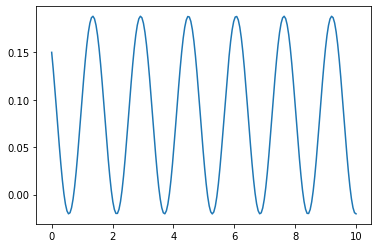

In [544]:
# O = np.kron(np.kron(I,Y), np.kron(I, np.kron(I,I)))
O = np.kron(np.kron(I,Y), np.kron(I,I))
exact_Z1 = [(np.conj(psi) @ O @ psi).real for psi in exact_te]
# trot_Z1 = [(np.conj(psi) @ O @ psi).real for psi in trot_te]

plt.plot(ts, exact_Z1)
# plt.plot(ts, trot_Z1)


In [550]:
def flatten_with_arrays(lst):
    flattened = []
    for item in lst:
        if isinstance(item, list):
            flattened.extend(flatten_with_arrays(item))
        elif isinstance(item, np.ndarray):
            flattened.append(item)
        else:
            flattened.append(item)
    return flattened

K = 1
CSk = [[init]]

for k in range(1,K+1):
    tmp = []
    for psi in CSk[k-1]:
        for U in Us:
            tmp.append(U @ psi)
    CSk.append(tmp)
    
CSk = flatten_with_arrays(CSk)
indexes = np.unique(np.array(CSk), axis=0, return_index=True)[1]
CSk = [CSk[index] for index in sorted(indexes)]
alpha0 = np.zeros(len(CSk))
alpha0[0] = 1
print(len(CSk))


3


In [551]:
def compute_D(K_moments, Ham):
    dim = len(K_moments)
    D = np.zeros((dim, dim), dtype=np.float32)

    for i in range(dim):
        for j in range(dim):
            D[i][j] = (np.conj(K_moments[i]) @ Ham @ K_moments[j]).real # shouldn't be an imaginary part
    return D

def compute_E(K_moments):
    dim = len(K_moments)
    E = np.zeros((dim, dim), dtype=np.float32)

    for i in range(dim):
        for j in range(dim):
            E[i][j] = (np.conj(K_moments[i]) @ K_moments[j]).real
    return E

print(np.round(compute_D(CSk, H), 3))
print()
print(np.round(compute_E(CSk), 3))

[[0.821 1.292 1.292]
 [1.292 0.821 0.821]
 [1.292 0.821 0.821]]

[[1.    0.377 0.444]
 [0.377 1.    0.292]
 [0.444 0.292 1.   ]]


In [552]:
D = compute_D(CSk, H)
E = compute_E(CSk)

ls, vs = eigh(D, E)

In [553]:
def QCSSEvolve(ls, vs, T, alpha0):
    dim = len(ls)
    csk_exp = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(dim):
        csk_exp += np.exp(-1j * ls[i] * T) * np.outer(vs[:, i], np.conj(vs[:, i])) @ E
    alphaT = csk_exp @ alpha0
    return sum([CSk[i] * alphaT[i] for i in range(dim)])

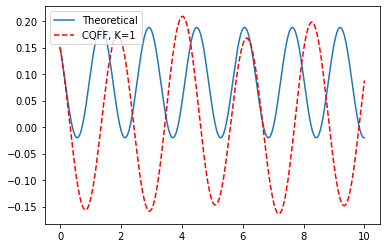

In [554]:
qcss_te = [QCSSEvolve(ls, vs, t, alpha0) for t in ts]
qcss_Z1 = [(np.conj(psi) @ O @ psi).real for psi in qcss_te]

plt.plot(ts, exact_Z1, label="Theoretical")
plt.plot(ts, qcss_Z1, 'r--', label="CQFF, K=1")
plt.legend(loc='upper left')